All Models Accuracy:
          model   feature_set  accuracy
0  DecisionTree           Raw  0.893242
1  RandomForest           Raw  0.959517
2  DecisionTree  LDA+Temporal  0.902079
3  RandomForest  LDA+Temporal  0.969071
4  DecisionTree           LDA  0.885957
5  RandomForest           LDA  0.924767
6  DecisionTree           PCA  0.751133
7  RandomForest           PCA  0.840577


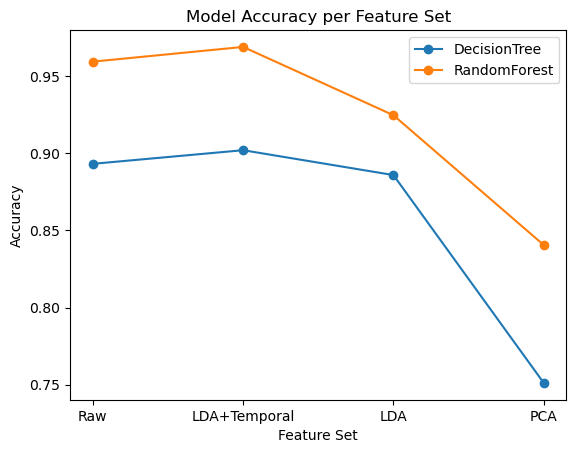

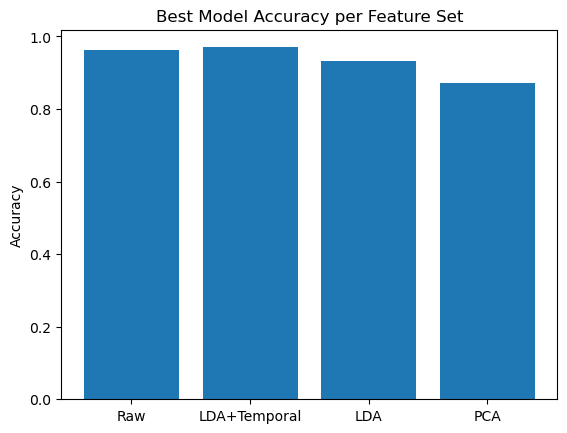

Feature Set: Raw, Model: RandomForest
Accuracy: 0.962385065477849
ROC AUC: 0
Classification Report: {'0': {'precision': 0.9352850539291218, 'recall': 0.9309815950920245, 'f1-score': 0.9331283627978478, 'support': 652.0}, '1': {'precision': 0.9695024077046549, 'recall': 0.9572107765451664, 'f1-score': 0.9633173843700159, 'support': 631.0}, '2': {'precision': 0.9370424597364568, 'recall': 0.9370424597364568, 'f1-score': 0.9370424597364568, 'support': 683.0}, '3': {'precision': 0.9906976744186047, 'recall': 1.0, 'f1-score': 0.9953271028037384, 'support': 426.0}, '4': {'precision': 0.9569120287253142, 'recall': 0.9655797101449275, 'f1-score': 0.9612263300270514, 'support': 552.0}, '5': {'precision': 0.9953632148377125, 'recall': 0.9984496124031008, 'f1-score': 0.9969040247678018, 'support': 645.0}, 'accuracy': 0.962385065477849, 'macro avg': {'precision': 0.9641338065586442, 'recall': 0.9648773589869459, 'f1-score': 0.9644909440838186, 'support': 3589.0}, 'weighted avg': {'precision': 0.96

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_pickle("../../data/partially processed/data_with_lda_pca.pkl")

# 2. Temporal abstraction (rolling mean example)
df['acc_x_roll'] = df.groupby('set')['acc_x'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['acc_y_roll'] = df.groupby('set')['acc_y'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['acc_z_roll'] = df.groupby('set')['acc_z'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['gyro_x_roll'] = df.groupby('set')['gyro_x'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['gyro_y_roll'] = df.groupby('set')['gyro_y'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['gyro_z_roll'] = df.groupby('set')['gyro_z'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split features
X_raw = df[['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']]
X_temporal = df[['acc_x_roll','acc_y_roll','acc_z_roll','gyro_x_roll','gyro_y_roll','gyro_z_roll']]
X_lda = df[['lda_1','lda_2','lda_3']]
X_pca = df[['pca_1','pca_2','pca_3']]
y = df['label_encoded']

# 3. Combine features for sets
# (1) raw acc+gyro
set1 = X_raw
# (2) lda + temporal
set2 = pd.concat([X_lda, X_temporal], axis=1)
# (3) lda only
set3 = X_lda
# (4) pca only
set4 = X_pca

feature_sets = [set1, set2, set3, set4]
feature_set_names = ["Raw", "LDA+Temporal", "LDA", "PCA"]

# 4. Feature selection with Decision Tree
def select_features(X, y):
    dt = DecisionTreeClassifier()
    dt.fit(X, y)
    return dt.feature_importances_

# 5. Grid search for multiple classifiers
models = {
    "DecisionTree": (DecisionTreeClassifier(), {"max_depth":[3,5,7]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators":[10,50,100], "min_samples_split":[2,5,10,30,60,100], "criterion":["gini","entropy"]}),
}

# Collect all models' best accuracy results
model_results = []

# 6. Train and evaluate
results = {}
for fs_name, fs_data in zip(feature_set_names, feature_sets):
    X_train, X_test, y_train, y_test = train_test_split(fs_data, y, test_size=0.3, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    best_score = 0
    best_model = None
    for name, (model, params) in models.items():
        gs = GridSearchCV(model, params, cv=3, scoring='accuracy')
        gs.fit(X_train_sc, y_train)
        model_results.append({
            "model": name,
            "feature_set": fs_name,
            "accuracy": gs.best_score_
        })
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = (name, gs.best_estimator_)

    # Evaluate best model
    pred = best_model[1].predict(X_test_sc)
    report = classification_report(y_test, pred, output_dict=True)
    roc = 0
    try:
        prob = best_model[1].predict_proba(X_test_sc)[:,1]
        roc = roc_auc_score(y_test, prob, multi_class='ovr')
    except:
        pass

    results[fs_name] = {
        "model": best_model[0],
        "accuracy": report["accuracy"],
        "classification_report": report,
        "roc_auc": roc
    }

# Assemble DataFrame of all models and feature sets
results_df = pd.DataFrame(model_results)
print("All Models Accuracy:")
print(results_df)

# Plot of each model accuracy per feature set
fig2, ax2 = plt.subplots()
for model_name, group in results_df.groupby('model'):
    ax2.plot(group['feature_set'], group['accuracy'], marker='o', label=model_name)
ax2.set_title("Model Accuracy per Feature Set")
ax2.set_xlabel("Feature Set")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

# 7. Plot results for best models
fig, ax = plt.subplots()
x_vals = np.arange(len(results))
acc_vals = [results[k]["accuracy"] for k in results]
ax.bar(x_vals, acc_vals, tick_label=list(results.keys()))
ax.set_ylabel("Accuracy")
ax.set_title("Best Model Accuracy per Feature Set")
plt.show()

# Print final
for fs_name, info in results.items():
    print(f"Feature Set: {fs_name}, Model: {info['model']}")
    print("Accuracy:", info['accuracy'])
    print("ROC AUC:", info['roc_auc'])
    print("Classification Report:", info['classification_report'])
    print("------------------------------------")

#### przeczytać inżynierke oskara zwlaszcza sekcje podsumowanie 
#### sprawdzic czy temporal ok
#### plot wplywu low pass filtra
#### plot temporala 
#### plot lda jesli ma sens
#### feature set wybrany przez decison tree temporal + lda + base do 10 cech limit
#### sprawdzić który model najszybciej dziala w czasie rzeczywistym ponieważ zastosowanie tego ma byc na urządzeniach przenośnych
#### przydatność cech statystyki
#### lepsze loggowanie wyników grid searcha 



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
#df = pd.read_csv('../../data/partially processed/filtered_data.csv')
    
#print(df.head())

#df, pca_explained_variance_ratio, lda_explained_variance_ratio = perform_pca_lda(df)
#plot_explained_variance(lda_explained_variance_ratio, 'LDA Scree Plot', 'Linear Discriminant', 'Explained Variance Ratio')
#plot_explained_variance(pca_explained_variance_ratio, 'PCA Scree Plot', 'Principal Component', 'Explained Variance Ratio')
#compare_random_forest(df, df, ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"], "label", "lda")
#df.head(10).to_csv('data/partially processed/sample.csv', index=False)

#unique_sets = df['set'].unique()
#columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
#df = apply_rolling_mean(df, unique_sets, columns)
#df.to_pickle('data/partially processed/data_with_engineered_features.pkl')
#print(df.head())

df = pd.read_pickle('data/partially processed/data_with_engineered_features.pkl')

set_to_plot = 4
subset_df = df[df['set'] == set_to_plot]
plt.plot(subset_df['acc_y'], label='acc_y')
plt.plot(subset_df['acc_y_roll'], label='acc_y_roll')
plt.legend()
plt.show()


                epoch (ms)     acc_x     acc_y     acc_z    gyro_x    gyro_y  \
0  2019-01-11 15:08:05.250  0.013539  0.976963 -0.071008 -0.799803  0.346723   
1  2019-01-11 15:08:05.400  0.008801  0.972525 -0.067207 -2.026645  0.341313   
2  2019-01-11 15:08:05.550 -0.000602  0.969439 -0.067167  0.851869 -0.700265   
3  2019-01-11 15:08:05.700 -0.012942  0.968605 -0.074572  5.521545 -2.676472   
4  2019-01-11 15:08:05.850 -0.020260  0.967225 -0.088278  6.145255 -3.999351   

     gyro_z participant  label category  set  duration  
0  5.177134           B  bench    heavy   30      16.0  
1  1.687114           B  bench    heavy   30      16.0  
2 -0.837993           B  bench    heavy   30      16.0  
3 -1.245872           B  bench    heavy   30      16.0  
4  0.109344           B  bench    heavy   30      16.0  


NameError: name 'perform_pca_lda' is not defined